# Python pour le Big Data

Pour ce projet, on se propose d'analyser les relations et causalités de différentes variables tirées de données calculées à partir de données de la blockchain Bitcoin.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as plotly_express
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler

## Visualisation des données

### Chargement des données

In [2]:
external_df = pd.read_csv('timeseries/external.csv')
global_df = pd.read_csv('timeseries/global.csv')

# Rename the first column of dates from 'Unnamed: 0' to 'Date'
global_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
external_df = external_df.drop(columns=['Unnamed: 0']).rename(columns={'date': 'Date'})

# Set the 'Date' column as the index
global_df.set_index('Date', inplace=True)
external_df.set_index('Date', inplace=True)

external_df.head()

,PriceUSD,HashRate
Date,,
2015-01-02,315.942732,333345.017260
2015-01-03,285.647310,327284.198765
2015-01-04,263.334575,347486.927083
2015-01-05,275.003852,315162.561773
2015-01-06,287.549521,319203.107437


En ce qui concerne les données fournies par le fichier `global.csv`, on s'intéressera aux variables suivantes:
* nb_transactions: nombre total de transactions
* nb_payments: nombre total de paiements (un paiement peut être composé de plusieurs transactions)
* nb_mining: Nombre de minages
* newly_created_coins: Nombre de bitcoins créés

Nous allons donc filter les données pour ne garder que ces variables. Il est important de noter que les données représentent des séries temporelles, donc il est nécessaire garder également les données relatives aux dates.

In [3]:
global_df = global_df[['nb_transactions', 'nb_payments', 'nb_mining', 'newly_created_coins']]
global_df.head()

,nb_transactions,nb_payments,nb_mining,newly_created_coins
Date,,,,
2015-01-01,58882,161194,166,415000000000
2015-01-02,77439,257633,166,415000000000
2015-01-03,83644,295618,166,415000000000
2015-01-04,85893,280288,173,432500000000
2015-01-05,94862,286552,155,387500000000


Concaténons maintenant les deux dataframes pour créer un 'super' dataframe contenant toutes les données que nous allons utiliser.

In [4]:
# Concatenate the two dataframes
df = pd.concat([global_df, external_df], axis=1)
df.head()

,nb_transactions,nb_payments,nb_mining,newly_created_coins,PriceUSD,HashRate
Date,,,,,,
2015-01-01,58882,161194,166,415000000000,NaN,NaN
2015-01-02,77439,257633,166,415000000000,315.942732,333345.017260
2015-01-03,83644,295618,166,415000000000,285.647310,327284.198765
2015-01-04,85893,280288,173,432500000000,263.334575,347486.927083
2015-01-05,94862,286552,155,387500000000,275.003852,315162.561773


### Prétraitement des données (normalisation, lissage, etc.)

In [5]:
# Save the dataframe indices and columns
columns = df.columns
indices = df.index

# Normalize the data
normalized_df = StandardScaler().fit_transform(df)
normalized_df = pd.DataFrame(np.array(normalized_df, dtype=np.float64), columns=columns, index=indices)

# Data smoothing
normalized_df = pd.DataFrame(normalized_df).rolling(7).mean()

### Affichage des données

Affichons les données par paires pour gagner en compréhension.

In [6]:
fig = plotly_express.line(normalized_df, x=normalized_df.index, y=['PriceUSD', 'HashRate'], title='Bitcoin price and hashrate and blockchain activity')
fig.show()

fig = plotly_express.line(normalized_df, x=normalized_df.index, y=['nb_transactions', 'nb_payments'], title='Bitcoin transactions and payments')
fig.show()

fig = plotly_express.line(normalized_df, x=normalized_df.index, y=['nb_mining', 'newly_created_coins'], title='Bitcoin mining and newly created coins')
fig.show()

![alternative text](./pics/price_and_hashrate.png)
![alternative text](./pics/transactions_and_payments.png)
![alternative text](./pics/mining_and_newly_created_coins.png)

En observant les graphiques, on remarque une certaine ressemblance entre les variables `nb_transactions` et `nb_payments` ainsi qu'entre `PriceUSD` et `HashRate`. Ce n'est pourant pas l'impression que donne la représentation des variables `nb_mining` et `newly_created_coins` qui semblent être très différentes. Il serait donc intéressant de regarder les corrélations entre toutes ces variables.

## Analyse des données

### Corrélation

#### PriceUSD et HashRate

In [7]:
sub_df = df[['PriceUSD', 'HashRate']].dropna()

# Compute the correlation matrix
corr_mat = sub_df.corr()
corr_coeff = corr_mat.loc['PriceUSD', 'HashRate']

print('Correlation coefficient: {:.2f}'.format(corr_coeff))

Correlation coefficient: 0.94


Le coefficient de corrélation entre `PriceUSD` et `HashRate` est de ~0.94. Cela signifie que les deux variables sont très fortement corrélées. Cela est une observation logique car plus le prix du bitcoin augmente, plus les mineurs sont motivés à miner, et plus la puissance de calcul utilisée augmente augmente. On peut déduire que la puissance de calcul est une variable explicative de la valeur du bitcoin.

#### nb_transactions et nb_payments

Une transaction pouvant être composé de plusieurs paiements, on peut s'attendre à ce que les deux variables soient fortement corrélées. Vérifions cette hypothèse.

In [8]:
sub_df = df[['nb_transactions', 'nb_payments']].dropna()

# Compute the correlation matrix
corr_mat = sub_df.corr()
corr_coeff = corr_mat.loc['nb_transactions', 'nb_payments']

print('Correlation coefficient: {:.2f}'.format(corr_coeff))

Correlation coefficient: 0.76


Ici, le coefficient de corrélation est également élevé (≈0.75), mais moins que pour `PriceUSD` et `HashRate`. Pourtant comme nous avons pu le mentionner, on observe une certaine ressemblance entre les deux graphiques. En revanche, on peut observer sur le plot qu'il y a une forme d'irrégularité dans les données dans la période de Juillet à Octobre 2015. Vérifions à quel point cette irrégularité est importante dans le calcul du coefficient de corrélation globale.

In [9]:
extracted_sub_df = sub_df.loc[(sub_df.index < '2015-07-01') | (sub_df.index > '2015-10-01')]
irregular_sub_df = sub_df.loc[(sub_df.index >= '2015-07-01') & (sub_df.index <= '2015-10-01')]

# Compute the correlation matrix
corr_mat = extracted_sub_df.corr()
corr_coeff = corr_mat.loc['nb_transactions', 'nb_payments']
print('Correlation coefficient (extracted data): {:.2f}'.format(corr_coeff))

# Compute the correlation matrix
corr_mat = irregular_sub_df.corr()
corr_coeff = corr_mat.loc['nb_transactions', 'nb_payments']
print('Correlation coefficient (irregular data): {:.2f}'.format(corr_coeff))

Correlation coefficient (extracted data): 0.97
Correlation coefficient (irregular data): 0.45


Ces résulats sont cohérents avec les graphiques. En effet, entre Juillet et Octobre 2015, les deux variables se "décorrelent". Le signe du coefficient de corrélation (positif), nous indique que lorsque l'une augmente, l'autre augmente également, mais les valeurs sont très différentes.

En revanche, en dehors de cette période, les deux variables sont très corrélées, avec un coefficient très élevé (≈0.97). On en déduit alors que les deux variables sont très fortement corrélées, mais que cette corrélation est très perturbée par une irrégularité dans les données, entre Juillet et Octobre 2015.

Comparons graphiquement les deux variables pour mieux comprendre cette irrégularité.

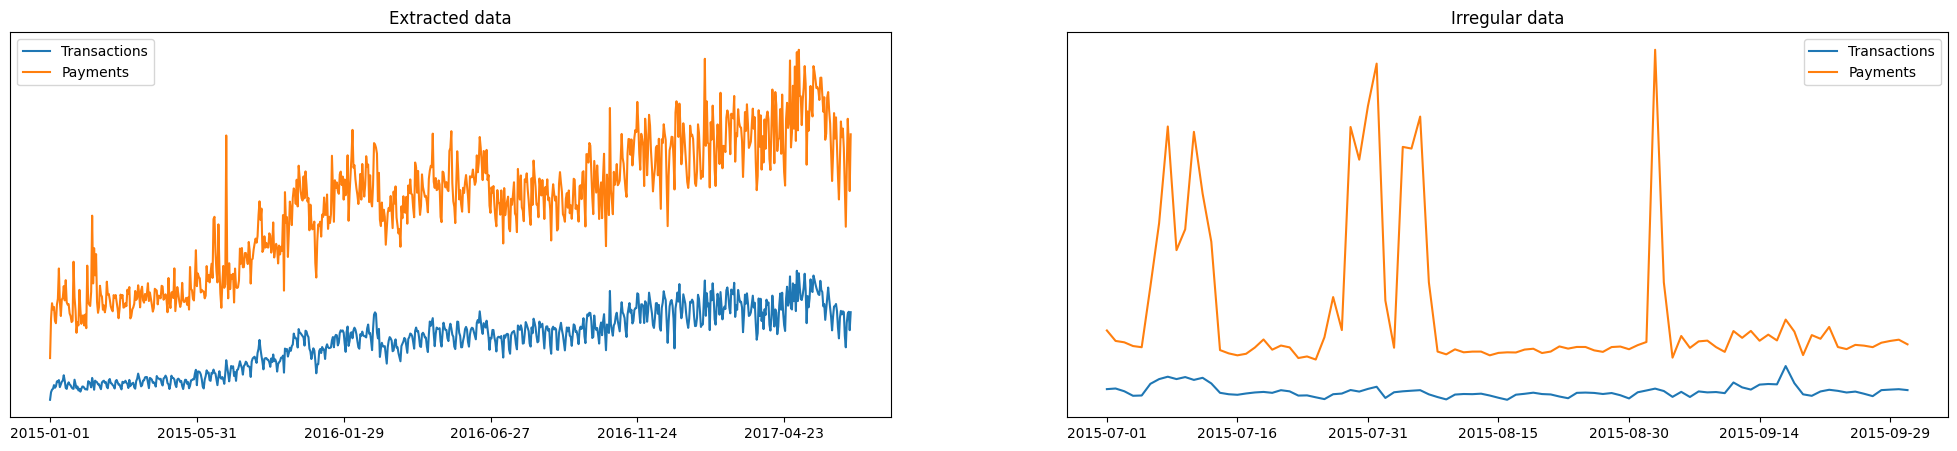

In [40]:
_, ax = plt.subplots(1, 2, figsize=(25, 5))

def display_comparison_plot(ax, df, title):
    ax.plot(df.index, df['nb_transactions'], label='Transactions')
    ax.plot(df.index, df['nb_payments'], label='Payments')
    ax.set_title(title)
    ax.legend()
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.set_yticks([])

display_comparison_plot(ax[0], extracted_sub_df, 'Extracted data')
display_comparison_plot(ax[1], irregular_sub_df, 'Irregular data')
plt.show()

#### nb_mining et newly_created_coins

In [41]:
sub_df = df[['nb_mining', 'newly_created_coins']].dropna()

# Compute the correlation matrix
corr_mat = sub_df.corr()
corr_coeff = corr_mat.loc['nb_mining', 'newly_created_coins']

print('Correlation coefficient: {:.2f}'.format(corr_coeff))

Correlation coefficient: 0.27


Nous avons pu observer au travers des graphiques que les deux variables avaient des valeurs très différentes et la variance de `newly_created_coins` était très élevée. Grâce au coefficient de corrélation, nous pouvons confirmer cette observation. En effet, le coefficient de corrélation est très faible (≈0.27). On peut donc déduire que les deux variables ne sont pas corrélées, même si le coefficient de corrélation est positif. En d'autres termes, il n'existe probablement pas de relation linéaire entre les deux variables.

#### nb_mining et HashRate

Il est intéressant de comparer la puissance de calcul utilisée pour miner et le nombre de minages. En effet, on pourrait s'attendre à ce que les deux variables soient liées, car plus il y a de minages, plus il y a de puissance de calcul utilisée au total. Vérifions cette hypothèse.

In [54]:
sub_df = df[['nb_mining', 'HashRate']].dropna()

# Compute the correlation matrix
corr_mat = sub_df.corr()
corr_coeff = corr_mat.loc['nb_mining', 'HashRate']

print('Correlation coefficient: {:.2f}'.format(corr_coeff))

Correlation coefficient: 0.15


Dans cette comparaison, on observe une corrélation positive, mais très faible (≈0.15). Par conséquent, notre hypothèse est fausse. On en déduit qu'il n'y a pas de relation linéaire entre les deux variables, et que la puissance de calcul utilisée pour miner ne dépend très peu du nombre de minages.

En revanche, on déduit logiquement et également grâce au signe du coefficient de corrélation, que plus il y a de minages, plus il y a de puissance de calcul utilisée au total.

### Autocorrélation